### Imports

In [1]:
import os
import torch
import imageio
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIV_PINN_model import StreamfunctionNetwork, HydroNetwork, WeakPINN

### Import data and make grids

In [2]:
data_path = '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/'

# FLUID DATA
mat = loadmat(data_path + 'flow_final.mat')
# for key, value in mat.items(): print(key)

frames = 10  # frames to load (if you don't want to load all of them)
# Get spacetime coordinates (x, y, t) and velocity components (u, v)
y, x, t, v, u = mat['x'], mat['y'], np.linspace(0, len(mat['x'])-1, len(mat['x'])), \
    mat['u'], mat['v']

# u, v = [u[i][0] for i in range(len(u))], [v[i][0] for i in range(len(v))]
u, v = torch.tensor(u, dtype=torch.float, requires_grad=False), torch.tensor(v, dtype=torch.float, requires_grad=False)
# u, v, t = u[:frames,...], v[:frames,...], t[:frames,...]
u, v, t = u[...,:frames], v[...,:frames], t[...,:frames]
    
x_grid, y_grid, t_grid = torch.tensor(x[0][0][:, 0], dtype=torch.float, requires_grad=True), torch.tensor(y[0][0][0][:], dtype=torch.float, requires_grad=True), \
    torch.linspace(0, int(t[-1]), int(t[-1]+1), requires_grad=True)

# T, X, Y = torch.meshgrid( (t_grid, x_grid, y_grid) )

X, Y, T = torch.meshgrid( (x_grid, y_grid, t_grid) )

print(Y.shape, u.shape)
print(torch.max(u))

torch.Size([35, 50, 10]) torch.Size([35, 50, 10])
tensor(4.1736)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visual Checks

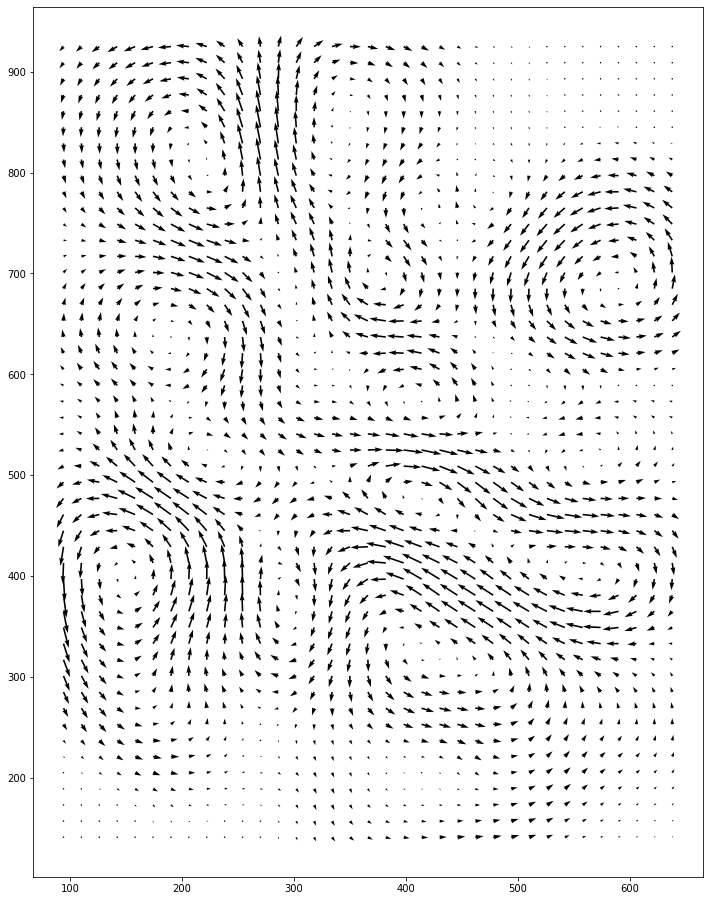

In [3]:
# Check the input flow field
fig, ax = plt.subplots(figsize=(12,16))
# ax.quiver(X[0,...].detach().numpy(), Y[0,...].detach().numpy(), u[0,...], v[0,...])
ax.quiver(X[...,0].detach().numpy(), Y[...,0].detach().numpy(), u[...,0], v[...,0])
plt.show()


torch.Size([50, 35, 10]) torch.Size([50, 35, 10])


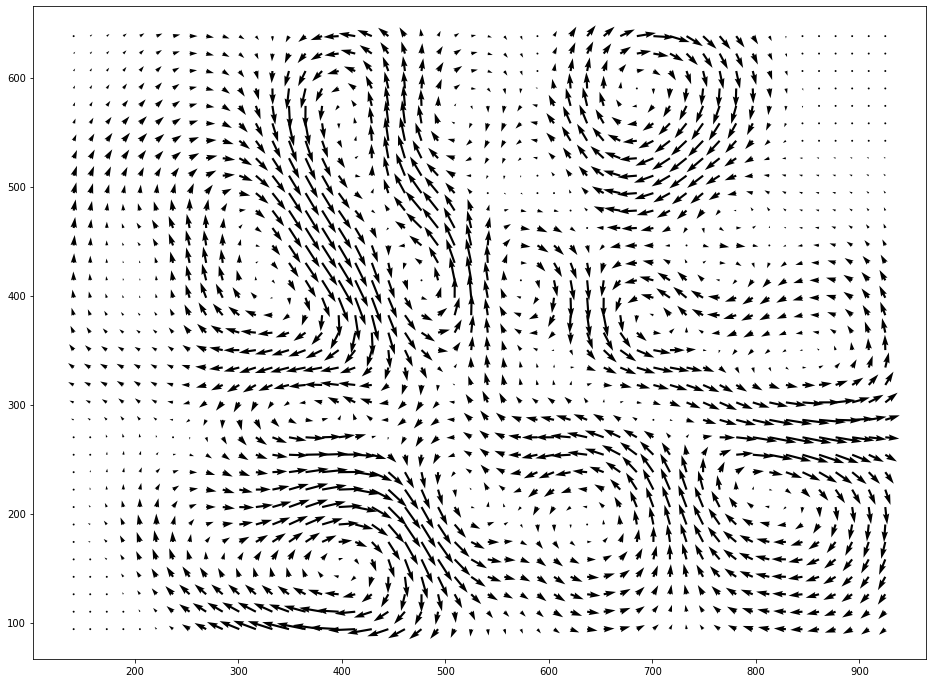

In [4]:
data_path = '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/'

# FLUID DATA
mat = loadmat(data_path + 'flow_final.mat')
# for key, value in mat.items(): print(key)

frames = 10  # frames to load (if you don't want to load all of them)
# Get spacetime coordinates (x, y, t) and velocity components (u, v)
x, y, t, u, v = mat['x'], mat['y'], np.linspace(0, len(mat['x'])-1, len(mat['x'])), mat['u'], mat['v']

u, v = torch.tensor(u, dtype=torch.float, requires_grad=False), torch.tensor(v, dtype=torch.float, requires_grad=False)
u, v = u.transpose(0,1), v.transpose(0,1)
u, v, t = u[...,:frames], v[...,:frames], t[...,:frames]
    
x_grid, y_grid, t_grid = torch.tensor(x[0][0][0][:], dtype=torch.float, requires_grad=True), torch.tensor(y[0][0][:, 0], dtype=torch.float, requires_grad=True), \
    torch.linspace(0, int(t[-1]), int(t[-1]+1), requires_grad=True)

X, Y, T = torch.meshgrid( (x_grid, y_grid, t_grid) )

print(Y.shape, u.shape)

# Check the input flow field
fig, ax = plt.subplots(figsize=(16,12))
frame=4
ax.quiver(X[...,frame].detach().numpy(), Y[...,frame].detach().numpy(), u[...,frame], v[...,frame])
plt.show()

# Create a gif of the input flow field
# for frame in range(frames):
#     u_i, v_i = u[...,frame], v[...,frame]
    
#     plt.close('all')
#     plt.quiver(X[...,frame].detach().numpy(), Y[...,frame].detach().numpy(), u_i, v_i)
#     plt.savefig(f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/images/input{frame}.png', dpi=300)

# filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/images/input{frame}.png' for frame in range(frames)]
# images = [imageio.imread(filename) for filename in filenames]
# imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/input.gif', images, fps=5)

In [5]:
MSE_losses = []
NSE_losses = []
wall_losses = []

### Make NN

In [6]:
X = torch.reshape( X, [-1,1] )
Y = torch.reshape( Y, [-1,1] )
T = torch.reshape( T, [-1,1] )

xs      = torch.cat( (X,Y,T), dim=1 )
xs_uniform = xs.clone().detach()
true_data = (torch.tensor(u, dtype=torch.float, requires_grad=False), torch.tensor(v, dtype=torch.float, requires_grad=False))
frame = 0

# Parameters
epochs=200
epoch=1

nu = 1.0
nu = torch.nn.Parameter(torch.tensor(nu, dtype=torch.float, requires_grad=True))

stream_model = StreamfunctionNetwork( L=64 )
hydro_model = HydroNetwork( stream_model )
pinn = WeakPINN( hydro_model, nu )

psi = stream_model.forward(xs)
f   = hydro_model.forward(xs)
err = pinn.forward(xs, true_data, (x_grid, y_grid, t_grid), epoch, epochs)

criterion = nn.MSELoss()
optimizer = optim.Adam(hydro_model.parameters(), lr=0.1)

loss_history = torch.zeros( (epochs) )

def save_network_output( hydro_model, out_name, grids ):
    # After training, you can use the trained model for predictions
    
    x_grid, y_grid, t_grid = grids[0], grids[1], grids[2]
    ns=( len(x_grid),len(y_grid),len(t_grid) )

    f_final, NSE = hydro_model.forward(xs)  # contains [w, u, v, T, a]

    f_final = f_final.detach().numpy()
    x_grid  = x_grid.detach().numpy()
    y_grid  = y_grid.detach().numpy()

    f_final = np.reshape( f_final, [ns[0], ns[1], ns[2], -1] )

    out_dict =  {"f": f_final, "x_grid": x_grid, "y_grid": y_grid, "loss_history": loss_history }
    savemat(out_name, out_dict)

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_31878/1914930574.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_data = (torch.tensor(u, dtype=torch.float, requires_grad=False), torch.tensor(v, dtype=torch.float, requires_grad=False))


### Run training loop

In [7]:
activations_list = []

if os.path.exists('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/model_dict_smooth.pth'): 
    pinn.load_state_dict(torch.load('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/model_dict_smooth.pth'))
    pinn.eval()

for epoch in range(epochs):
    # Forward pass
    NSE, u_n, v_n = pinn.forward(xs, true_data, (x_grid, y_grid, t_grid), epoch, epochs)
    
    def LOSS():
        loss = criterion(NSE, torch.zeros_like(NSE)) + criterion(u_n, true_data[0]) + criterion(v_n, true_data[1])

        NSE_err = criterion(NSE.float(), torch.zeros_like(NSE).float())
        
        MSE_err = torch.abs( u_n[:, :, :frames].flatten() - true_data[0][:, :].flatten() ) + torch.abs( v_n[:, :, :frames].flatten() - true_data[1][:, :].flatten() )
        MSE_err = criterion(MSE_err, torch.zeros_like(MSE_err))
        
        NSE_losses.append(NSE_err.item())
        MSE_losses.append(MSE_err.item())
        
        return loss

    # Backward pass and optimization step
    optimizer.zero_grad()  # clear previous gradients
    loss = LOSS()
    loss.backward(retain_graph=True)   # compute gradients
    optimizer.step()  # update model parameters
    activations_list.append(stream_model.activations)
    
    # Print the loss every few epochs
    if epoch % 2 == 0:
        print(f"Frame {frame}, Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        
# Save the model to reload for the next frame
torch.save(pinn.state_dict(), '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/model_dict_smooth.pth')

# Make gif
filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/images/reconstruction{i}.png' for i in range(len(t_grid))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/2DPINNs/New Data/2/reconstruction.gif', images, fps=5)

Frame 0, Epoch 0/200, Loss: 4.405436992645264
Frame 0, Epoch 2/200, Loss: 4.4036149978637695
Frame 0, Epoch 4/200, Loss: 4.395187854766846
Frame 0, Epoch 6/200, Loss: 4.365321159362793
Frame 0, Epoch 8/200, Loss: 4.283210754394531
Frame 0, Epoch 10/200, Loss: 4.167222499847412
Frame 0, Epoch 12/200, Loss: 4.002485275268555
Frame 0, Epoch 14/200, Loss: 3.8481009006500244
Frame 0, Epoch 16/200, Loss: 3.6569766998291016
Frame 0, Epoch 18/200, Loss: 3.4663171768188477
Frame 0, Epoch 20/200, Loss: 3.246150016784668
Frame 0, Epoch 22/200, Loss: 2.9807024002075195
Frame 0, Epoch 24/200, Loss: 2.677548408508301
Frame 0, Epoch 26/200, Loss: 2.385756492614746
Frame 0, Epoch 28/200, Loss: 2.1508255004882812
Frame 0, Epoch 30/200, Loss: 1.9846197366714478
Frame 0, Epoch 32/200, Loss: 1.7689719200134277
Frame 0, Epoch 34/200, Loss: 1.571777582168579
Frame 0, Epoch 36/200, Loss: 1.4227135181427002
Frame 0, Epoch 38/200, Loss: 1.2871556282043457
Frame 0, Epoch 40/200, Loss: 1.1514358520507812
Frame 0

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_31878/895662964.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


(17500, 32)


(array([2771., 2625., 1523., 1045.,  786.,  786., 1045., 1523., 2625.,
        2771.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

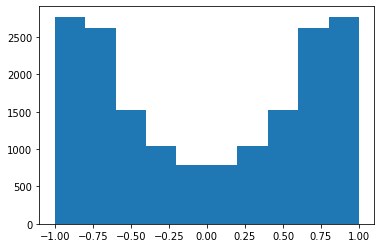

In [8]:
print(activations_list[0].shape)
plt.hist(activations_list[0][:,3])

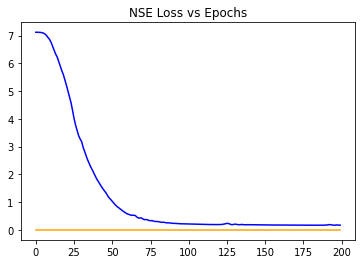

In [10]:
# plt.plot(MSE_losses, color='blue')
plt.plot(NSE_losses, color='orange')
plt.title('NSE Loss vs Epochs')
plt.show()

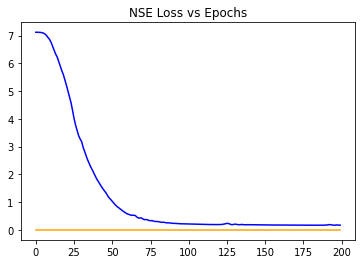

In [ ]:
plt.plot(MSE_losses, color='blue')
plt.plot(NSE_losses, color='orange')
plt.title('NSE Loss vs Epochs')
plt.show()